In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from models.cmlp import cMLP
import pickle
import yaml

In [6]:
data_catagory = 'endogenous'
data_path = f'../data/{data_catagory}.pickle'
with open('../configs/train_cmlp.yaml', "r") as stream:
    cfg = yaml.safe_load(stream)
    model_cfg = cfg['model']

In [7]:
with open(data_path, 'rb') as f:
    data = pickle.load(f)
    print(f'{data_catagory} data loaded...')
    X = data['Y']
    GC = data['GC']

endogenous data loaded...


In [8]:
cmlp = cMLP(30, lag=model_cfg['lag'], hidden=[model_cfg['hidden']]).cuda(device=model_cfg['device'])

In [10]:
cmlp.load_state_dict(torch.load(f'./saved_models/cmlp_{data_catagory}.pt'))

<All keys matched successfully>

True variable usage = 6.56%
--------------------------------------------------
Threshold = 0
Estimated variable usage = 15.78%
Accuracy = 87.67%
--------------------------------------------------
Threshold = 0.22
Estimated variable usage = 7.22%
Accuracy = 94.89%


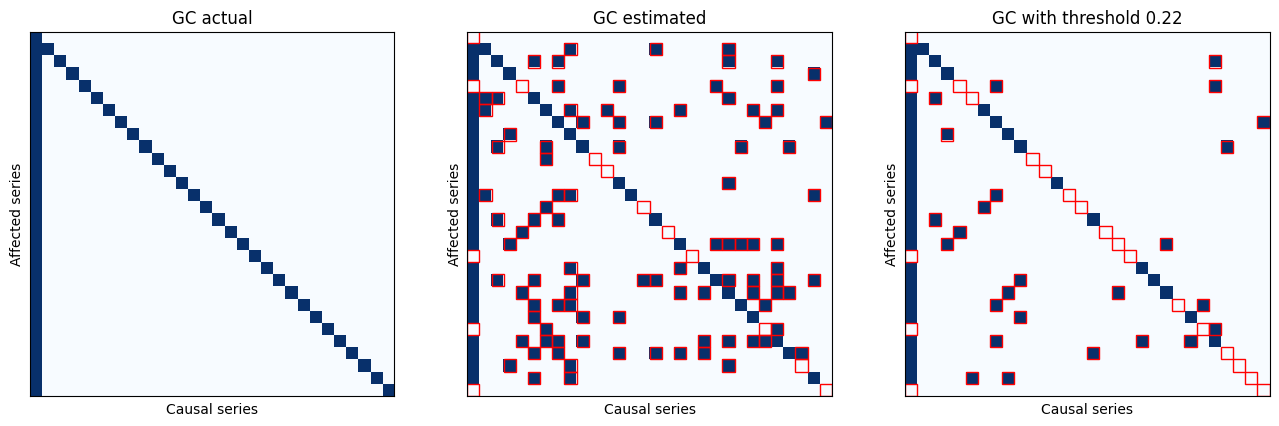

In [14]:
# Verify learned Granger causality
thres = 0.22
GC_est = cmlp.GC().cpu().data.numpy()
GC_thres = cmlp.GC(thres_value=thres).cpu().data.numpy()

print('True variable usage = %.2f%%' % (100 * np.mean(GC)))
print('-'*50)
print('Threshold = 0')
print('Estimated variable usage = %.2f%%' % (100 * np.mean(GC_est)))
print('Accuracy = %.2f%%' % (100 * np.mean(GC == GC_est)))
print('-'*50)
print(f'Threshold = {thres}')
print(f'Estimated variable usage = %.2f%%' % (100 * np.mean(GC_thres)))
print(f'Accuracy = %.2f%%' % (100 * np.mean(GC == GC_thres)))

# Make figures
fig, axarr = plt.subplots(1, 3, figsize=(16, 10))
axarr[0].imshow(GC, cmap='Blues')
axarr[0].set_title('GC actual')
axarr[0].set_ylabel('Affected series')
axarr[0].set_xlabel('Causal series')
axarr[0].set_xticks([])
axarr[0].set_yticks([])

axarr[1].imshow(GC_est, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_est), len(GC_est), 0))
axarr[1].set_title('GC estimated')
axarr[1].set_ylabel('Affected series')
axarr[1].set_xlabel('Causal series')
axarr[1].set_xticks([])
axarr[1].set_yticks([])

axarr[2].imshow(GC_thres, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_thres), len(GC_thres), 0))
axarr[2].set_title(f'GC with threshold {thres}')
axarr[2].set_ylabel('Affected series')
axarr[2].set_xlabel('Causal series')
axarr[2].set_xticks([])
axarr[2].set_yticks([])

# Mark disagreements
for i in range(len(GC_est)):
    for j in range(len(GC_est)):
        if GC[i, j] != GC_est[i, j]:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[1].add_patch(rect)

for i in range(len(GC_thres)):
    for j in range(len(GC_thres)):
        if GC[i, j] != GC_thres[i, j]:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[2].add_patch(rect)
plt.show()